# Multi-state SurvNODE implementation minimizing the negative log-likelihood

In this notebook we show examples of the analyses done in the paper using the SurvNODE implementation minimizing the negative log-likelihood. Pretrained models are available for random_seed=137

In [1]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
# from torchdiffeq import odeint_adjoint as odeint
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#from lifelines import CoxPHFitter
#from lifelines import KaplanMeierFitter

#from pycox.evaluation import EvalSurv

In [2]:
random_seed = 137
torch.manual_seed(random_seed)
np.random.seed(random_seed)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

print(device)

cuda:0


In [4]:
# Early stopping class from https://github.com/Bjarten/early-stopping-pytorch
from SurvNODE.EarlyStopping import EarlyStopping
from SurvNODE.SurvNODE import *

# Application to the special case of survival

Data generated with the 'coxed' R package

In [5]:
survdata = pd.read_csv("Data/survival_sim_km.csv").drop(columns="Unnamed: 0")

## Kaplan-Meier comparison

create a binary covariate for the Kaplan-Meier estimates by splitting e.g. $X_3$ into 0/1

In [6]:
survdata["covar"] = (survdata.X3>0).astype("int")

survdata_train = survdata.sample(n=2048)
survdata_val = survdata[~survdata.index.isin(survdata_train.index)].sample(n=1024)
survdata_test = survdata[~np.logical_or(survdata.index.isin(survdata_train.index),survdata.index.isin(survdata_val.index))].sample(n=1024)

Using the lifelines package, we obtain the non-parametric Kaplan-Meier estimate of the test data. We furthermore train the Cox proportional hazards model on the union of train- and validation data.

Preparation of the data set in the format we need it

In [7]:
def get_dataset(df,Tmax):
    x = torch.from_numpy(np.array(df[["covar"]])).float().to(device)
    Tstart = torch.from_numpy(np.array(df[["Tstart"]])).flatten().float().to(device)
    Tstop = torch.from_numpy(np.array(df[["Tstop"]])).flatten().float().to(device)
    Tstart = Tstart/Tmax*multiplier
    Tstop = Tstop/Tmax*multiplier
    From = torch.from_numpy(np.array(df[["From"]])).flatten().int().to(device)
    To = torch.from_numpy(np.array(df[["To"]])).flatten().int().to(device)
    trans = torch.from_numpy(np.array(df[["trans"]])).flatten().int().to(device)
    status = torch.from_numpy(np.array(df[["status"]])).flatten().float().to(device)
    dataset = TensorDataset(x,Tstart,Tstop,From,To,trans,status)
    return dataset

multiplier = 1.
Tmax = max(torch.from_numpy(np.array(survdata[["Tstop"]])).flatten().float().to(device))

train_loader = DataLoader(get_dataset(survdata_train,Tmax), batch_size=512, shuffle=True)
val_loader = DataLoader(get_dataset(survdata_val,Tmax), batch_size=512, shuffle=True)

Initialization of the model

In [8]:
num_in = 1
num_latent = 10
layers_encoder = [800]*2
dropout_encoder = [0.1]*2
layers_odefunc = [1000]*3
dropout_odefunc = []

trans_matrix = torch.tensor([[np.nan,1],[np.nan,np.nan]]).to(device)

encoder = Encoder(num_in,num_latent,layers_encoder, dropout_encoder).to(device)
odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc).to(device)
block = ODEBlock(odefunc).to(device)
odesurv = SurvNODE(block,encoder).to(device)

optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-6, lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.1)

We train the model first with weight decay $10^{-6}$ and a learning rate of $10^{-3}$ and then with a weight decay of $10^{-7}$ and learning rate $10^{-4}$ to refine the solution with early stopping on the validation set

Un-comment for the training procedure. The pre-trained model is available further down.

In [10]:
early_stopping = EarlyStopping("Checkpoints/surv",patience=20, verbose=True)
for i in tqdm(range(500)):
    odesurv.train()
    for mini,ds in enumerate(train_loader):
        myloss,t2,_ = loss(odesurv,*ds)
        optimizer.zero_grad()
        myloss.backward()    
        optimizer.step()
        
    odesurv.eval()
    with torch.no_grad():
        lossval = 0
        for _,ds in enumerate(val_loader):
            t1,t2,_ = loss(odesurv,*ds)
            lossval += t1.item()
    
#     scheduler.step()
    early_stopping(lossval/len(val_loader), odesurv)
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# odesurv.load_state_dict(torch.load('Checkpoints/surv_checkpoint.pt'))

# optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-7, lr=1e-4)
# early_stopping = EarlyStopping("Checkpoints/surv",patience=20, verbose=True)
# for i in tqdm(range(500)):
#     odesurv.train()
#     for mini,ds in enumerate(train_loader):
#         myloss,t2,_ = loss(odesurv,*ds)
#         optimizer.zero_grad()
#         myloss.backward()    
#         optimizer.step()
        
#     odesurv.eval()
#     with torch.no_grad():
#         lossval = 0
#         for _,ds in enumerate(val_loader):
#             t1,t2,_ = loss(odesurv,*ds)
#             lossval += t1.item()
    
# #     scheduler.step()
#     early_stopping(lossval/len(val_loader), odesurv)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
        
# odesurv.load_state_dict(torch.load('Checkpoints/surv_checkpoint.pt'))

  0%|          | 0/500 [00:00<?, ?it/s]

TIME 0 Pf 0.0 1.0 Pb 0.0 1.0
TIME 1 Pf 0.0 1.0 Pb -0.0020662248134613037 1.0020670890808105
TIME 2 Pf 0.0 1.0 Pb -0.002508881501853466 1.0025089979171753
TIME 3 Pf 0.0 1.0 Pb -0.0043227775022387505 1.0043234825134277
TIME 4 Pf 0.0 1.0 Pb -0.006264460738748312 1.006264328956604
TIME 5 Pf 0.0 1.0 Pb -0.009332303889095783 1.009332537651062
TIME 6 Pf 0.0 1.0 Pb -0.014359181746840477 1.014358401298523
TIME 7 Pf 0.0 1.0 Pb -0.017990736290812492 1.0179907083511353
TIME 8 Pf 0.0 1.0 Pb -0.022632906213402748 1.022632122039795
TIME 9 Pf 0.0 1.0 Pb -0.02851446159183979 1.028511881828308
TIME 10 Pf 0.0 1.0 Pb -0.03590983524918556 1.03590989112854
TIME 11 Pf 0.0 1.0 Pb -0.045085977762937546 1.0450866222381592
TIME 12 Pf 0.0 1.0 Pb -0.056232716888189316 1.0562347173690796
TIME 13 Pf 0.0 1.0 Pb -0.06955510377883911 1.0695551633834839
TIME 14 Pf 0.0 1.0 Pb -0.10340750217437744 1.1034069061279297
TIME 15 Pf 0.0 1.0 Pb -0.1242111474275589 1.1242111921310425
TIME 16 Pf 0.0 1.0 Pb -0.14774473011493683 1.1

KeyboardInterrupt: 

Loading the pre-trained model

Visual comparison of the non-parametric estimator and the two predictions.

## Cox-model comparison

We can use the data-set with all three covariates and train both Cox model and the SurvNODE model and then compare concordance, integrated Brier score and integrated negative binomial log likelihood.

In [13]:
def get_dataset(df,Tmax):
    x = torch.from_numpy(np.array(df[["X1","X2","X3"]])).float().to(device)
    Tstart = torch.from_numpy(np.array(df[["Tstart"]])).flatten().float().to(device)
    Tstop = torch.from_numpy(np.array(df[["Tstop"]])).flatten().float().to(device)
    Tstart = Tstart/Tmax*multiplier
    Tstop = Tstop/Tmax*multiplier
    From = torch.from_numpy(np.array(df[["From"]])).flatten().int().to(device)
    To = torch.from_numpy(np.array(df[["To"]])).flatten().int().to(device)
    trans = torch.from_numpy(np.array(df[["trans"]])).flatten().int().to(device)
    status = torch.from_numpy(np.array(df[["status"]])).flatten().float().to(device)
    dataset = TensorDataset(x,Tstart,Tstop,From,To,trans,status)
    return dataset

multiplier = 1.
Tmax = max(torch.from_numpy(np.array(survdata[["Tstop"]])).flatten().float().to(device))

train_loader = DataLoader(get_dataset(survdata_train,Tmax), batch_size=512, shuffle=True)
val_loader = DataLoader(get_dataset(survdata_val,Tmax), batch_size=512, shuffle=True)
test_loader = DataLoader(get_dataset(survdata_test,Tmax), batch_size=512, shuffle=True)

In [14]:
cox_df = pd.DataFrame({"T":np.concatenate((survdata_train.Tstop,survdata_val.Tstop)),
                       "E": np.concatenate((survdata_train.status,survdata_val.status)),
                       "X1":np.concatenate((survdata_train.X1,survdata_val.X1)),
                       "X2":np.concatenate((survdata_train.X2,survdata_val.X2)),
                       "X3":np.concatenate((survdata_train.X3,survdata_val.X3))}
                     )
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='T', event_col='E')

<lifelines.CoxPHFitter: fitted with 3072 total observations, 321 right-censored observations>

In [15]:
num_in = 3
num_latent = 400
layers_encoder = [800]*2
dropout_encoder = [0.1]*2
layers_odefunc = [1000]*3
dropout_odefunc = []

trans_matrix = torch.tensor([[np.nan,1],[np.nan,np.nan]]).to(device)

encoder = Encoder(num_in,num_latent,layers_encoder, dropout_encoder).to(device)
odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc).to(device)
block = ODEBlock(odefunc).to(device)
odesurv = SurvNODE(block,encoder).to(device)

optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-5, lr=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.1)

In [16]:
# early_stopping = EarlyStopping("Checkpoints/survival",patience=20, verbose=True)
# for i in tqdm(range(500)):
#     odesurv.train()
#     for mini,ds in enumerate(train_loader):
#         myloss,t2,_ = loss(odesurv,*ds)
#         optimizer.zero_grad()
#         myloss.backward()    
#         optimizer.step()
        
#     odesurv.eval()
#     with torch.no_grad():
#         lossval = 0
#         for _,ds in enumerate(val_loader):
#             t1,t2,_ = loss(odesurv,*ds)
#             lossval += t1.item()
    
# #     scheduler.step()
#     early_stopping(lossval/len(val_loader), odesurv)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
        
# odesurv.load_state_dict(torch.load('Checkpoints/survival_checkpoint.pt'))

Pre-trained model

In [17]:
odesurv.load_state_dict(torch.load('Checkpoints/survival_checkpoint.pt'))

<All keys matched successfully>

Concordance, integrated Brier score and integrated negative binomial log likelihood of the SurveNODE model

In [18]:
measures(odesurv,torch.tensor([1.,0.],device=device),test_loader)

(0.6590134713755168, 0.10327642468172973, 0.3180434822374892)

Concordance, integrated Brier score and negative binomial log likelihood of the Cox proportional hazards model

In [19]:
cox_df = survdata_test.loc[:,["Tstop","status","X1","X2","X3"]]

pred = cph.predict_survival_function(cox_df.loc[:,["X1","X2","X3"]])

ev_ode = EvalSurv(pred, cox_df['Tstop'].to_numpy(), cox_df['status'].to_numpy(), censor_surv='km')
conc = ev_ode.concordance_td('antolini')
time_grid = np.linspace(0, cox_df['Tstop'].max(), 500)
ibs = ev_ode.integrated_brier_score(time_grid)
inbll = ev_ode.integrated_nbll(time_grid)

print(conc,ibs,inbll)

0.6464574136360451 0.10984730609446368 0.3399210339255206


# Multi-state models

## Illness-Death model compared to Aaalen-Johansen

Data generated with "coxed" R package (see supplement), Aalen-Johansen estimator and Markov Cox proportional hazards model generated with "mstate" R package.

In [20]:
prob_hr_train = pd.read_csv("Data/multistate_aj_1_train.csv")
prob_lr_train = pd.read_csv("Data/multistate_aj_0_train.csv")
prob_hr_test = pd.read_csv("Data/multistate_aj_1_train.csv")
prob_lr_test = pd.read_csv("Data/multistate_aj_0_train.csv")
prob_cox_hr = pd.read_csv("Data/multistate_cox_1_train.csv")
prob_cox_lr = pd.read_csv("Data/multistate_cox_0_train.csv")
df_trainval = pd.read_csv("Data/multistate_trainval.csv")
df_test = pd.read_csv("Data/multistate_test.csv")

df_train = df_trainval.sample(n=2048)
df_val = df_trainval[~df_trainval.index.isin(df_train.index)].sample(n=1024)

We can again do a visual comparison of the non-parametric model with the two prediction models: A markovian multistate Cox model and the SurvNODE model.

In [21]:
def get_dataset(df,Tmax):
    x = torch.from_numpy(np.array(df[["covariate"]])).float().to(device)
    Tstart = torch.from_numpy(np.array(df[["Tstart"]])).flatten().float().to(device)
    Tstop = torch.from_numpy(np.array(df[["Tstop"]])).flatten().float().to(device)
    Tstart = Tstart/Tmax*multiplier
    Tstop = Tstop/Tmax*multiplier
    From = torch.from_numpy(np.array(df[["from"]])).flatten().int().to(device)
    To = torch.from_numpy(np.array(df[["to"]])).flatten().int().to(device)
    trans = torch.from_numpy(np.array(df[["trans"]])).flatten().int().to(device)
    status = torch.from_numpy(np.array(df[["status"]])).flatten().float().to(device)

    dataset = TensorDataset(x,Tstart,Tstop,From,To,trans,status)
    return dataset


multiplier = 1.
Tmax = max(torch.from_numpy(np.array(df_train[["Tstop"]])).flatten().float().to(device))

train_loader = DataLoader(get_dataset(df_train,Tmax),batch_size=512, shuffle=True)
val_loader = DataLoader(get_dataset(df_val,Tmax),batch_size=512, shuffle=True)

In [22]:
num_in = 1
num_latent = 20
layers_encoder = [800]*2
dropout_encoder = [0.]*2
layers_odefunc = [1000]*3
dropout_odefunc = []

trans_matrix = torch.tensor([[np.nan,1,1],[np.nan,np.nan,1],[np.nan,np.nan,np.nan]]).to(device)

encoder = Encoder(num_in,num_latent,layers_encoder, dropout_encoder).to(device)
odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc).to(device)
block = ODEBlock(odefunc).to(device)
odesurv = SurvNODE(block,encoder).to(device)

optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-6, lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.1)

In [23]:
# early_stopping = EarlyStopping("Checkpoints/idm",patience=20, verbose=True)
# for i in tqdm(range(500)):
#     odesurv.train()
#     for mini,ds in enumerate(train_loader):
#         myloss,t2,_ = loss(odesurv,*ds)
#         optimizer.zero_grad()
#         myloss.backward()    
#         optimizer.step()
        
#     odesurv.eval()
#     with torch.no_grad():
#         lossval = 0
#         for _,ds in enumerate(val_loader):
#             t1,t2,_ = loss(odesurv,*ds)
#             lossval += t1.item()
    
# #     scheduler.step()
#     early_stopping(lossval/len(val_loader), odesurv)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
        
# odesurv.load_state_dict(torch.load('Checkpoints/idm_checkpoint.pt'))

# optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-7, lr=1e-4)

# early_stopping = EarlyStopping("Checkpoints/idm",patience=20, verbose=True)
# for i in tqdm(range(500)):
#     odesurv.train()
#     for mini,ds in enumerate(train_loader):
#         myloss,t2,_ = loss(odesurv,*ds)
#         optimizer.zero_grad()
#         myloss.backward()    
#         optimizer.step()
        
#     odesurv.eval()
#     with torch.no_grad():
#         lossval = 0
#         for _,ds in enumerate(val_loader):
#             t1,t2,_ = loss(odesurv,*ds)
#             lossval += t1.item()
    
# #     scheduler.step()
#     early_stopping(lossval/len(val_loader), odesurv)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
        
# odesurv.load_state_dict(torch.load('Checkpoints/idm_checkpoint.pt'))

Pre-trained model

In [24]:
odesurv.load_state_dict(torch.load('Checkpoints/idm_checkpoint.pt'))

<All keys matched successfully>

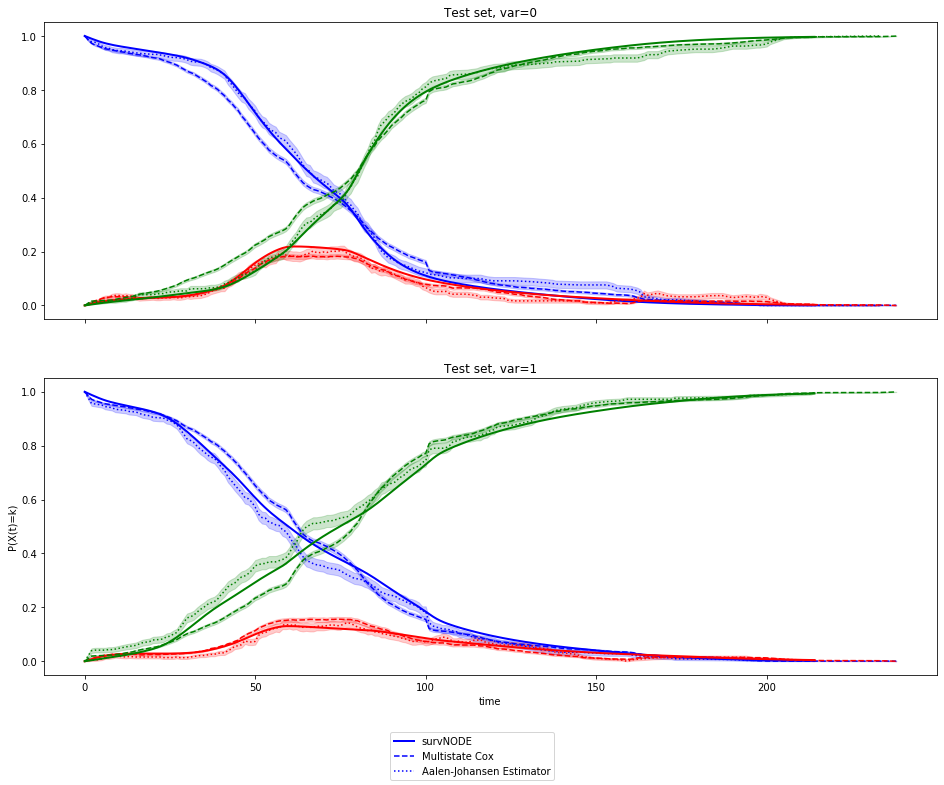

In [25]:
temp_t = torch.from_numpy(np.linspace(0.,multiplier*1.0,200))
with torch.no_grad():
    out = odesurv.predict(torch.tensor([[0.],[1.]],device=device),temp_t).cpu()

pvec = torch.einsum("ikj,k->ij",(out[:,0,:,:],torch.tensor([1.,0.,0.])))
fig,((ax1,ax2)) = plt.subplots(2,1,figsize=(16,12),sharex=True,sharey=True)
col = ["blue","red","green"]
for j in range(pvec.shape[1]):
    ax1.plot(np.array(temp_t)*np.array(Tmax.cpu())/multiplier,pvec[:,j],color=col[j],lw=2)
    ax1.plot(prob_cox_lr[["time"]],prob_cox_lr[["pstate"+str(j+1)]],color=col[j], ls="--")
    ax1.fill_between(np.array(prob_cox_lr[["time"]]).flatten(),np.array(prob_cox_lr[["pstate"+str(j+1)]]).flatten()-np.array(prob_cox_lr[["se"+str(j+1)]]).flatten(),np.array(prob_cox_lr[["pstate"+str(j+1)]]).flatten()+np.array(prob_cox_lr[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
    ax1.plot(prob_lr_test[["time"]],prob_lr_test[["pstate"+str(j+1)]],color=col[j],ls=":")
    ax1.fill_between(np.array(prob_lr_test[["time"]]).flatten(),np.array(prob_lr_test[["pstate"+str(j+1)]]).flatten()-np.array(prob_lr_test[["se"+str(j+1)]]).flatten(),np.array(prob_lr_test[["pstate"+str(j+1)]]).flatten()+np.array(prob_lr_test[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
ax1.set_title("Test set, var=0")
pvec = torch.einsum("ikj,k->ij",(out[:,1,:,:],torch.tensor([1.,0.,0.])))
for j in range(pvec.shape[1]):
    ax2.plot(np.array(temp_t)*np.array(Tmax.cpu())/multiplier,pvec[:,j],color=col[j],lw=2,label="survNODE")
    ax2.plot(prob_cox_hr[["time"]],prob_cox_hr[["pstate"+str(j+1)]],color=col[j], ls="--",label="Multistate Cox")
    ax2.fill_between(np.array(prob_cox_hr[["time"]]).flatten(),np.array(prob_cox_hr[["pstate"+str(j+1)]]).flatten()-np.array(prob_cox_hr[["se"+str(j+1)]]).flatten(),np.array(prob_cox_hr[["pstate"+str(j+1)]]).flatten()+np.array(prob_cox_hr[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
    ax2.plot(prob_hr_test[["time"]],prob_hr_test[["pstate"+str(j+1)]],color=col[j],ls=":",label="Aalen-Johansen Estimator")
    ax2.fill_between(np.array(prob_hr_test[["time"]]).flatten(),np.array(prob_hr_test[["pstate"+str(j+1)]]).flatten()-np.array(prob_hr_test[["se"+str(j+1)]]).flatten(),np.array(prob_hr_test[["pstate"+str(j+1)]]).flatten()+np.array(prob_hr_test[["se"+str(j+1)]]).flatten(),color=col[j],alpha=0.2)
ax2.set_title("Test set, var=1")
plt.xlabel("time")
plt.ylabel("P(X(t)=k)")
handles, labels = ax2.get_legend_handles_labels()
fig.legend([handles[0],handles[1],handles[2]],[labels[0],labels[1],labels[2]], loc='lower center')
plt.show()

## Competing risks

Benchmark on competing risks dataset from DeepHit paper

In [26]:
from sklearn.model_selection import train_test_split

url = 'https://raw.githubusercontent.com/chl8856/DeepHit/master/sample%20data/SYNTHETIC/synthetic_comprisk.csv'
df_train = pd.read_csv(url)

# In the data there are a lot of non-sensical t=0 event times. 
# To make sense of those events as happening very quickly, we put those at t=0.5, which is smaller than
# any other event time in the data: min(t[t!=0])=1
df_train.loc[df_train.time==0,"time"] = 0.5

df_train.loc[:,"Tstop"] = df_train.loc[:,"time"].astype("float32")
df_train.loc[:,"Tstart"] = 0.
df_train.loc[:,"status"] = df_train.loc[:,"label"]>0
df_train.loc[:,"from"] = 1
df_train.loc[:,"to"] = df_train.loc[:,"true_label"]+1
df_train.loc[:,"trans"] = df_train.loc[:,"true_label"]

df_train, df_test = train_test_split(df_train,shuffle=True,stratify=df_train.loc[:,"status"].values)
df_train, df_val = train_test_split(df_train,shuffle=True,stratify=df_train.loc[:,"status"].values)

get_x = lambda df: (df.drop(columns=['time', 'label', 'true_time', 'true_label',"Tstart","Tstop","from","to","status","trans"]).values.astype('float32'))
x_train = get_x(df_train)
x_val = get_x(df_val)
x_test = get_x(df_test)

multiplier = 1.
Tmax = max(torch.from_numpy(np.array(df_train[["Tstop"]])).flatten().float().to(device))

In [27]:
def get_dataset(df,Tmax):
    x = torch.from_numpy(np.array(df[["feature"+str(i) for i in range(1,13)]])).float().to(device)
    Tstart = torch.from_numpy(np.array(df[["Tstart"]])).flatten().float().to(device)
    Tstop = torch.from_numpy(np.array(df[["Tstop"]])).flatten().float().to(device)
    Tstart = Tstart/Tmax*multiplier
    Tstop = Tstop/Tmax*multiplier
    From = torch.from_numpy(np.array(df[["from"]])).flatten().int().to(device)
    To = torch.from_numpy(np.array(df[["to"]])).flatten().int().to(device)
    trans = torch.from_numpy(np.array(df[["trans"]])).flatten().int().to(device)
    status = torch.from_numpy(np.array(df[["status"]])).flatten().float().to(device)

    dataset = TensorDataset(x,Tstart,Tstop,From,To,trans,status)
    return dataset

train_loader = DataLoader(get_dataset(df_train,Tmax), batch_size=512, shuffle=True)
val_loader = DataLoader(get_dataset(df_val,Tmax), batch_size=512, shuffle=True)
test_loader = DataLoader(get_dataset(df_test,Tmax), batch_size=512, shuffle=True)

In [28]:
num_in = 12
num_latent = 30
layers_encoder = [400]*2
dropout_encoder = [0.1]*2
layers_odefunc = [1000]*2
dropout_odefunc = []

trans_matrix = torch.tensor([[np.nan,1.,1.],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]]).to(device)
print(trans_matrix)

encoder = Encoder(num_in,num_latent,layers_encoder, dropout_encoder).to(device)
odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc).to(device)
block = ODEBlock(odefunc).to(device)
odesurv = SurvNODE(block,encoder).to(device)

optimizer = torch.optim.Adam(odesurv.parameters(),weight_decay=1e-3, lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5)

tensor([[nan, 1., 1.],
        [nan, nan, nan],
        [nan, nan, nan]], device='cuda:0')


In [29]:
# early_stopping = EarlyStopping("Checkpoints/competing",patience=10, verbose=True)
# for i in tqdm(range(500)):
#     odesurv.train()
#     for _,ds in enumerate(train_loader):
#         myloss,_,_ = loss(odesurv,*ds)
#         optimizer.zero_grad()
#         myloss.backward()    
#         optimizer.step()
        
#     odesurv.eval()
#     with torch.no_grad():
#         lossval = 0
#         for _,ds in enumerate(val_loader):
#             myloss,_,_ = loss(odesurv,*ds)
#             lossval += myloss.item()
#     
# #     scheduler.step()
#     early_stopping(lossval/len(val_loader), odesurv)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
        
# odesurv.load_state_dict(torch.load('Checkpoints/competing_checkpoint.pt'))

Pre-trained model

In [30]:
odesurv.load_state_dict(torch.load('Checkpoints/competing_checkpoint.pt'))

<All keys matched successfully>

Cause specific concordances of event 1 and event 2

In [31]:
temp_t = torch.from_numpy(np.linspace(0.,multiplier*1.0,500))
prediction = []
durations_vec = []
events_vec = []
to_vec = []
with torch.no_grad():
    for df in test_loader:
        out = odesurv.predict(df[0],temp_t).cpu()
        pvec = torch.einsum("ilkj,k->ilj",(out,torch.tensor([1.,0.,0.])))
        prediction.append(pvec)
        durations_vec.append(df[2])
        events_vec.append(df[6])
        to_vec.append(df[4])
prediction = torch.cat(prediction,dim=1)
durations_vec = torch.cat(durations_vec)
events_vec = torch.cat(events_vec)
to_vec = torch.cat(to_vec)

cif1 = pd.DataFrame(1-prediction[:,:,1].numpy())
cif1 = cif1.set_index(np.linspace(0.,1.0,500)*Tmax.cpu().numpy())
cif2 = pd.DataFrame(1-prediction[:,:,2].numpy())
cif2 = cif2.set_index(np.linspace(0.,1.0,500)*Tmax.cpu().numpy())

ev1 = EvalSurv(cif1, durations_vec.cpu().numpy()*Tmax.item()/multiplier, events_vec.cpu().numpy()*(to_vec==2).cpu().numpy(), censor_surv='km')
ev2 = EvalSurv(cif2, durations_vec.cpu().numpy()*Tmax.item()/multiplier, events_vec.cpu().numpy()*(to_vec==3).cpu().numpy(), censor_surv='km')

print(ev1.concordance_td("antolini"))
print(ev2.concordance_td("antolini"))

0.7447824115372698
0.7480802877666569
